* Revenue = previous revenue + future revenue based on churn probability
* CAC = average CAC per channel
* CLV = Revenue - CAC


Discount rate: 10%

Assumptions:
* Customers will pay monthly price in future (not discount price)
* Revenue from first period was revenue_net
* Churn probability is the same in every period

In [112]:
# read in libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [113]:
# discount rate at 10% annually
# discount renews every 4 months
r = 0.1 / 3

In [117]:
# read in data
subscribers = pd.read_pickle('data/subscribers')

channelcac = pd.read_pickle('channel_cac')
churnpred = pd.read_pickle('current_churnpred')

spend = pd.read_csv('data/advertisingspend.csv')
spend['month'] = pd.to_datetime(spend['date'], infer_datetime_format=True).dt.to_period('M')
spend = spend.drop('date', axis = 1)

In [120]:
channelcac

,spend,total_acq,cac
attribution_technical,,,
affiliate,139500,20954.257097,6.657358
brand sem intent google,216100,51593.482678,4.188514
email,760600,70207.763551,10.833560
email_blast,226400,24871.003067,9.102970
facebook,552700,184734.062718,2.991868
pinterest,63300,12608.766411,5.020317
referral,73400,19059.223668,3.851154
search,232500,54115.259631,4.296385


In [118]:
# join the tables together
df_clv = churnpred.merge(subscribers[['subid', 'attribution_technical', 'revenue_net', 'monthly_price', 'discount_price']], 
                         on = 'subid')

df_clv = df_clv.merge(channelcac.reset_index()[['attribution_technical','cac']], 
                      on ='attribution_technical', how ='left')

In [119]:
df_clv.isna().sum()

subid                       0
churn_prob                  0
attribution_technical       0
revenue_net              9112
monthly_price               0
discount_price              0
cac                      5564
dtype: int64

In [18]:
df_clv.describe()

,subid,churn_prob,revenue_net,discount_price,cac
count,1.922200e+04,19222.000000,10110.000000,19222.000000,19222.000000
mean,2.499507e+07,0.711278,5.035912,4.514066,4.004222
std,2.900322e+06,0.273163,1.470139,0.003041,3.644879
min,2.000060e+07,0.000000,1.835000,4.220500,0.000000
25%,2.245798e+07,0.506757,4.587500,4.514100,0.000000
50%,2.498781e+07,0.752067,4.587500,4.514100,3.269265
75%,2.755131e+07,1.000000,4.917800,4.514100,4.697299
max,2.999994e+07,1.000000,10.422800,4.514100,11.766477


In [121]:
# cleaning up the table

# all channels that aren't account for, make cac 0
df_clv['cac'] = df_clv['cac'].fillna(0)

# if revenue net is null, then fill in with the mean value
df_clv['revenue_net'] = df_clv['revenue_net'].fillna(df_clv['revenue_net'].mean())

# channel names: group organic and other together
df_clv['attribution_technical'] = np.where(df_clv['attribution_technical'].isin(spend.columns), df_clv['attribution_technical'], 
                                                 np.where(df_clv['attribution_technical'].str.contains("organic"), "organic", 'other'))

df_clv.head()

,subid,churn_prob,attribution_technical,revenue_net,monthly_price,discount_price,cac
0,23796492,0.840580,organic,4.5875,4.7343,4.5141,0.000000
1,20162910,0.500000,brand sem intent google,4.5875,4.7343,4.5141,4.188514
2,22120282,0.271186,organic,4.8811,4.7343,4.5141,0.000000
3,22652005,0.417027,organic,4.5875,4.7343,4.5141,0.000000
4,25839343,0.696629,organic,4.5875,4.7343,4.5141,0.000000


In [122]:
# calculate clv
df_clv['future_rev'] = (df_clv['monthly_price'])* ((1+r)/(1+r-(1-df_clv['churn_prob']))) - (df_clv['monthly_price'])
df_clv['clv'] = df_clv['revenue_net'] + df_clv['future_rev'] - df_clv['cac']

clv_median = df_clv['clv'].median()
clv_mean = df_clv['clv'].mean()

df_clv.head()

,subid,churn_prob,attribution_technical,revenue_net,monthly_price,discount_price,cac,future_rev,clv
0,23796492,0.840580,organic,4.5875,4.7343,4.5141,0.000000,0.863637,5.451137
1,20162910,0.500000,brand sem intent google,4.5875,4.7343,4.5141,4.188514,4.438406,4.837393
2,22120282,0.271186,organic,4.8811,4.7343,4.5141,0.000000,11.330699,16.211799
3,22652005,0.417027,organic,4.5875,4.7343,4.5141,0.000000,6.128347,10.715847
4,25839343,0.696629,organic,4.5875,4.7343,4.5141,0.000000,1.967564,6.555064


In [123]:
print(clv_median)
print(clv_mean)

4.4422755621646
5.958199473261615


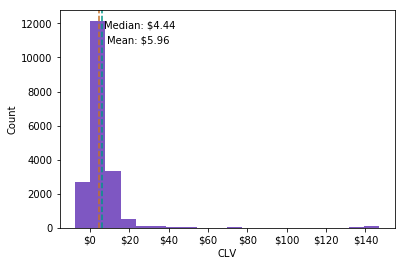

In [124]:
import matplotlib.ticker as ticker

formatter_x = ticker.FormatStrFormatter('$%1.0f')

fig, ax = plt.subplots(figsize=(6, 4))

ax.hist(df_clv['clv'], bins = 20, color = '#7e57c2')
ax.axvline(clv_median, color='#c77025', linestyle = "dashed")
ax.axvline(clv_mean, color='#009688', linestyle = "dashed")

ax.annotate('Median: ${:,.2f}'.format(clv_median), xy = (clv_median, 11900),
                  xytext=(5, -5),  # points vertical offset
                  textcoords="offset points", ha='left', va='bottom')
ax.annotate('Mean: ${:,.2f}'.format(clv_mean), xy = (clv_mean, 11900),
                  xytext=(5, -20), textcoords="offset points", ha='left', va='bottom')

ax.xaxis.set_major_formatter(formatter_x)
ax.set_ylabel('Count') 
ax.set_xlabel('CLV') 
plt.show()

In [125]:
df_clv['clv'].describe()

count    19222.000000
mean         5.958199
std         14.192876
min         -7.640660
25%          1.291226
50%          4.442276
75%          7.204039
max        147.064912
Name: clv, dtype: float64